# Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.utils import normalize
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras import backend as K
from keras import callbacks

In [ ]:
from skimage import io
import numpy as np
import nibabel as nib
import cv2

# Import Data

In [ ]:
# import data
!unzip /content/drive/MyDrive/BME548L_FinalProject/KFold/original_images.zip
!unzip /content/drive/MyDrive/BME548L_FinalProject/KFold/combined_masks.zip


Archive:  /content/drive/MyDrive/BME548L_FinalProject/KFold/original_images.zip
   creating: original_images/
  inflating: original_images/T0012AMRT(S)-0025.bmp  
  inflating: original_images/T0012AMRT(S)-0026.bmp  
  inflating: original_images/T0012AMRT(S)-0027.bmp  
  inflating: original_images/T0012AMRT(S)-0028.bmp  
  inflating: original_images/T0012AMRT(S)-0029.bmp  
  inflating: original_images/T0012AMRT(S)-0030.bmp  
  inflating: original_images/T0012AMRT(S)-0031.bmp  
  inflating: original_images/T0012AMRT(S)-0032.bmp  
  inflating: original_images/T0012AMRT(S)-0033.bmp  
  inflating: original_images/T0012AMRT(S)-0034.bmp  
  inflating: original_images/T0012AMRT(S)-0035.bmp  
  inflating: original_images/T0012AMRT(S)-0036.bmp  
  inflating: original_images/T0012AMRT(S)-0037.bmp  
  inflating: original_images/T0012AMRT(S)-0038.bmp  
  inflating: original_images/T0012AMRT(S)-0039.bmp  
  inflating: original_images/T0012AMRT(S)-0040.bmp  
  inflating: original_images/T0012AMRT(S)-

In [ ]:
image_directory = '/content/original_images/'
mask_directory = '/content/combined_masks/'


# Define Functions

In [ ]:
# get image and mask data for k-fold cross validation
def getTest(TestSubName, path):
    # if type == 'Mask':
      dataset = []
      # print((TestSubName[0]))
      all_images = glob.glob(os.path.join(path, TestSubName[0]+'*'))
      # print(all_images)
      for i, image_name in enumerate(all_images):
      # print(image_name)
        # if image_name.split('.')[1] == 'bmp':
        image = cv2.imread(image_name, 0)
        # print(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
      # if type == 'Mask':
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      # if type == 'Image':
      #   # dataset = np.expand_dims(normalize(np.array(dataset), axis=1), 3)
      #   dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      return dataset

def getTrain(restSubName, path):  
    # if type == 'Train':
      dataset = []
      for i, rest_sub_name in enumerate(restSubName):
        # print(rest_sub_name)
        all_images = glob.glob(os.path.join(path, rest_sub_name+'*'))
        # print(all_images)
        for i, image_name in enumerate(all_images):
          image = cv2.imread(image_name, 0)
          # print(image)
          image = Image.fromarray(image)
          image = image.resize((SIZE, SIZE))
          dataset.append(np.array(image))
      # if type == 'Mask':
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      # if type == 'Image':
      #   # dataset = np.expand_dims(normalize(np.array(dataset), axis=1), 3)
      #   dataset = np.expand_dims((np.array(dataset)), 3) / 255.0

      return dataset

In [ ]:
SIZE = 256
image_dataset = []
mask_dataset = []

Make sure getTrain and getTest properly separate data for k-fold cross validation.

In [ ]:
# check if getTrain and getTest functions worked
# Y = ['T0012', 'T0013', 'T0014']
Y = ['T0012', 'T0013', 'T0014']
for i, testSubName in enumerate(Y):
  testSubName = [testSubName]
  trainSubName = list(set(Y)-set(testSubName))
  print('testsub: ', testSubName, 'restSubNames: ', trainSubName)
  x_train = getTrain(trainSubName, image_directory)
  y_train = getTrain(trainSubName, mask_directory)
  x_test = getTest(testSubName, image_directory)
  y_test = getTest(testSubName, mask_directory)
  print(x_train.shape, x_test.shape)

testsub:  ['T0012'] restSubNames:  ['T0013', 'T0014']
(276, 256, 256, 1) (146, 256, 256, 1)
testsub:  ['T0013'] restSubNames:  ['T0014', 'T0012']
(283, 256, 256, 1) (139, 256, 256, 1)
testsub:  ['T0014'] restSubNames:  ['T0013', 'T0012']
(285, 256, 256, 1) (137, 256, 256, 1)


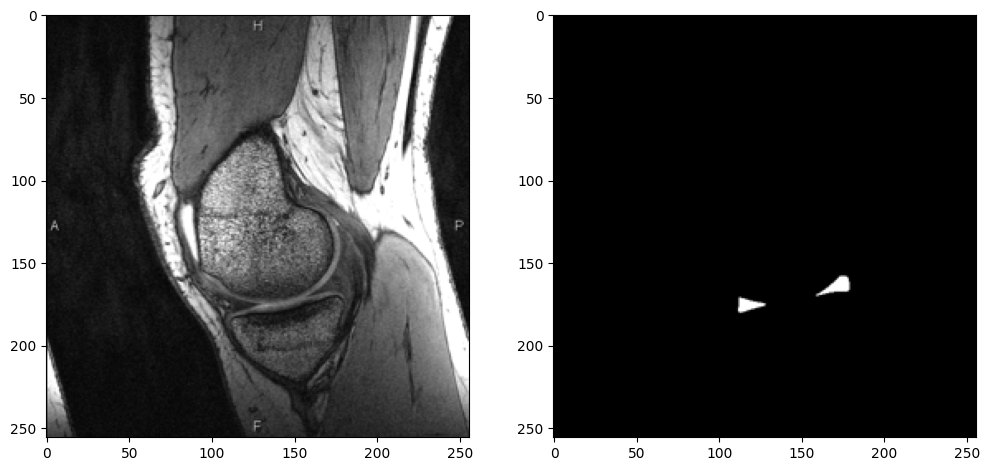

In [ ]:
import random
image_number = random.randint(0, len(x_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(x_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

In [ ]:
# Define losses
def DiceCoef(y_true, y_pred, smooth=1):
    # # y_pred_thresholded = y_pred > 0.5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.math.reduce_sum((y_true * y_pred),axis = (1,2,3))
    dice = (2 * intersection + smooth) / (tf.math.reduce_sum(y_true,axis = (1,2,3)) + tf.math.reduce_sum(y_pred,axis = (1,2,3)) + smooth)
    return dice


def DiceLoss(y_true, y_pred, smooth=1):
    print(y_true.shape, y_pred.shape)
    return 1 - DiceCoef(y_true, y_pred)

# UNet w/ Physical Layer Architecture


The physical layer masks the image in the fourier space to block out low frequencies and then recovers it to the spatial domain.

In [ ]:
# Implementation of physcial layer
# create high pass filter from FT
# width = 256, height = 256, n is the spectrum of low frequencies to block out (must be less than 128)
def HPF(width, height, n):
    # calculate the center point
    half_w, half_h = int(width/2), int(height/2)
    # initiate high pass filter
    HPF = np.ones((width, height))
    # block out low frequencies
    HPF[half_w-n:half_w+n+1, half_h-n:half_h+n+1] = 0
    return HPF

In [ ]:
# fftshift with tensorflow
def tf_fftshift2(A):
    # 2D fftshift
    # apply fftshift to the last two dims
    s = tf.shape(A)
    s1 = s[-2]
    s2 = s[-1]
    A = tf.concat([A[..., s1//2:, :], A[..., :s1//2, :]], axis=-2)
    A = tf.concat([A[..., :, s2//2:], A[..., :, :s2//2]], axis=-1)
    return A

In [ ]:
# Custom Layer
class PL_HPF(tf.keras.layers.Layer):
    def __init__(self):
        super(PL_HPF, self).__init__()
        
    def build(self, input_shape=(256,256,1)):
        self.filter = HPF(width=x_train.shape[1], height=x_train.shape[2], n=1)
        # self.filter = tf.cast(self.filter, dtype=tf.complex64)
        self.filter = tf.Variable(self.filter, trainable=True, dtype=tf.complex64)

    def get_filter(self):
        return self.filter

    def call(self, input):
        # trasnpose input shape (:, 256, 256, 1) to make shape (:, 1, 256, 256)
        x = tf.transpose(input, [0, 3, 1, 2])
        # convert to complex tensor
        x = tf.cast(x, dtype=tf.complex64)
        # apply 2D FT
        x = tf.signal.fft2d(x)
        # shift FT
        x = tf_fftshift2(x)
        # element-wise multiplication of HPF with FT of image
        x = tf.multiply(x, self.filter)
        # shift back
        x = tf_fftshift2(x)
        # inverse 2D FT
        x = tf.signal.ifft2d(x)
        # abolute value
        x = tf.abs(x)
        # transpose back to original shape
        x = tf.transpose(x, [0, 2, 3, 1])
        # convert back to float tensor
        x = tf.cast(x, dtype=tf.float32)      
        return x

In [ ]:
# build the 2-D unet model with physical layer
def PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # l1 = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    # physical layer
    PL = PL_HPF()(s)

    # encoding
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(PL)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    # p5 = MaxPooling2D((2,2))(c5)

    # decoding
    d6 = Conv2DTranspose(128, (2,2), strides=2, padding='same')(c5)
    d6 = concatenate([d6, c4]) # d6=d6+c4
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    d7 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(c6)
    d7 = concatenate([d7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    d8 = Conv2DTranspose(64, (2,2), strides=2, padding='same')(c7)
    d8 = concatenate([d8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    d9 = Conv2DTranspose(16, (2,2), strides=2, padding='same')(c8)
    d9 = concatenate([d9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(d9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=DiceLoss,
                  metrics=[DiceCoef, 'accuracy'])
    model.summary()

    return model


Define 3 models for the 3-fold cross-validation.

In [ ]:
PL_model1 = PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 pl_hpf (PL_HPF)                (None, 256, 256, 1)  65536       ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['pl_hpf[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
PL_model2 = PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 pl_hpf_1 (PL_HPF)              (None, 256, 256, 1)  65536       ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['pl_hpf_1[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
PL_model3 = PL_unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 pl_hpf_2 (PL_HPF)              (None, 256, 256, 1)  65536       ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 16  160         ['pl_hpf_2[0][0]']               
                                )                                                                 
                                                                                            

# Train Models

## Fold 1

In [ ]:
# Redefine training and test data
Y = ['T0012', 'T0013', 'T0014']
# for i, testSubName in enumerate(Y):
testSubName = ['T0012']
trainSubName = list(set(Y)-set(testSubName))
print('testsub: ', testSubName, 'restSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_train.shape, x_test.shape)

testsub:  ['T0012'] restSubNames:  ['T0013', 'T0014']
(276, 256, 256, 1) (146, 256, 256, 1)


In [ ]:
history = PL_model1.fit(x_train, y_train,
                    batch_size=8,
                    verbose=1,
                    epochs=80,
                    validation_data=(x_test, y_test),
                    shuffle=False)

PL_model1.save('/content/drive/MyDrive/BME548L_FinalProject/KFold/PLTrainedModels/meniscus_epoch80_f1.hdf5')

Epoch 1/80
(None, 256, 256, 1) (None, 256, 256, 1)
(None, 256, 256, 1) (None, 256, 256, 1)
35/35 [==============================] - 37s 253ms/step - loss: 0.9937 - DiceCoef: 0.0063 - accuracy: 0.6395 - val_loss: 0.9959 - val_DiceCoef: 0.0041 - val_accuracy: 0.9725
Epoch 2/80
35/35 [==============================] - 5s 132ms/step - loss: 0.9838 - DiceCoef: 0.0162 - accuracy: 0.7564 - val_loss: 0.9983 - val_DiceCoef: 0.0017 - val_accuracy: 0.9862
Epoch 3/80
35/35 [==============================] - 5s 142ms/step - loss: 0.9700 - DiceCoef: 0.0300 - accuracy: 0.7661 - val_loss: 0.9938 - val_DiceCoef: 0.0062 - val_accuracy: 0.9955
Epoch 4/80
35/35 [==============================] - 5s 133ms/step - loss: 0.9178 - DiceCoef: 0.0822 - accuracy: 0.7383 - val_loss: 0.9618 - val_DiceCoef: 0.0382 - val_accuracy: 0.9973
Epoch 5/80
35/35 [==============================] - 5s 141ms/step - loss: 0.8824 - DiceCoef: 0.1176 - accuracy: 0.7797 - val_loss: 0.9655 - val_DiceCoef: 0.0345 - val_accuracy: 0.9970

In [ ]:
dicecoeff1 = history.history['DiceCoef']
loss1 = history.history['loss']
accuracy1 = history.history['accuracy']

val_dicecoeff1 = history.history['val_DiceCoef']
val_loss1 = history.history['val_loss']
val_accurracy1 = history.history['val_accuracy']


## Fold 2

In [ ]:
# Redefine training and test data
Y = ['T0012', 'T0013', 'T0014']
# for i, testSubName in enumerate(Y):
testSubName = ['T0013']
trainSubName = list(set(Y)-set(testSubName))
print('testsub: ', testSubName, 'restSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_train.shape, x_test.shape)

testsub:  ['T0013'] restSubNames:  ['T0014', 'T0012']
(283, 256, 256, 1) (139, 256, 256, 1)


In [ ]:
history = PL_model2.fit(x_train, y_train,
                    batch_size=8,
                    verbose=1,
                    epochs=80,
                    validation_data=(x_test, y_test),
                    shuffle=False)

PL_model2.save('/content/drive/MyDrive/BME548L_FinalProject/KFold/PLTrainedModels/meniscus_epoch80_f2.hdf5')

Epoch 1/80
(None, 256, 256, 1) (None, 256, 256, 1)
(None, 256, 256, 1) (None, 256, 256, 1)
36/36 [==============================] - 25s 239ms/step - loss: 0.9903 - DiceCoef: 0.0097 - accuracy: 0.6551 - val_loss: 0.9974 - val_DiceCoef: 0.0026 - val_accuracy: 0.9981
Epoch 2/80
36/36 [==============================] - 5s 134ms/step - loss: 0.9657 - DiceCoef: 0.0343 - accuracy: 0.7541 - val_loss: 0.9801 - val_DiceCoef: 0.0199 - val_accuracy: 0.9981
Epoch 3/80
36/36 [==============================] - 5s 142ms/step - loss: 0.9401 - DiceCoef: 0.0599 - accuracy: 0.7897 - val_loss: 0.9975 - val_DiceCoef: 0.0025 - val_accuracy: 7.8577e-04
Epoch 4/80
36/36 [==============================] - 5s 137ms/step - loss: 0.9275 - DiceCoef: 0.0725 - accuracy: 0.8167 - val_loss: 0.9900 - val_DiceCoef: 0.0100 - val_accuracy: 0.8600
Epoch 5/80
36/36 [==============================] - 5s 136ms/step - loss: 0.8913 - DiceCoef: 0.1087 - accuracy: 0.7692 - val_loss: 0.9124 - val_DiceCoef: 0.0876 - val_accuracy: 0.

In [ ]:
dicecoeff2 = history.history['DiceCoef']
loss2 = history.history['loss']
accuracy2 = history.history['accuracy']

val_dicecoeff2 = history.history['val_DiceCoef']
val_loss2 = history.history['val_loss']
val_accurracy2 = history.history['val_accuracy']


## Fold 3

In [ ]:
# Redefine training and test data
Y = ['T0012', 'T0013', 'T0014']
# for i, testSubName in enumerate(Y):
testSubName = ['T0014']
trainSubName = list(set(Y)-set(testSubName))
print('testsub: ', testSubName, 'restSubNames: ', trainSubName)
x_train = getTrain(trainSubName, image_directory)
y_train = getTrain(trainSubName, mask_directory)
x_test = getTest(testSubName, image_directory)
y_test = getTest(testSubName, mask_directory)
print(x_train.shape, x_test.shape)

testsub:  ['T0014'] restSubNames:  ['T0013', 'T0012']
(285, 256, 256, 1) (137, 256, 256, 1)


In [ ]:
history = PL_model3.fit(x_train, y_train,
                    batch_size=8,
                    verbose=1,
                    epochs=80,
                    validation_data=(x_test, y_test),
                    shuffle=False)

PL_model3.save('/content/drive/MyDrive/BME548L_FinalProject/KFold/PLTrainedModels/meniscus_epoch80_f3.hdf5')

Epoch 1/80
(None, 256, 256, 1) (None, 256, 256, 1)
(None, 256, 256, 1) (None, 256, 256, 1)
36/36 [==============================] - 24s 255ms/step - loss: 0.9903 - DiceCoef: 0.0097 - accuracy: 0.6121 - val_loss: 0.9969 - val_DiceCoef: 0.0031 - val_accuracy: 0.9979
Epoch 2/80
36/36 [==============================] - 5s 138ms/step - loss: 0.9823 - DiceCoef: 0.0177 - accuracy: 0.7162 - val_loss: 0.9894 - val_DiceCoef: 0.0106 - val_accuracy: 0.9905
Epoch 3/80
36/36 [==============================] - 5s 136ms/step - loss: 0.9678 - DiceCoef: 0.0322 - accuracy: 0.7580 - val_loss: 0.9965 - val_DiceCoef: 0.0035 - val_accuracy: 0.2285
Epoch 4/80
36/36 [==============================] - 5s 144ms/step - loss: 0.9435 - DiceCoef: 0.0565 - accuracy: 0.7440 - val_loss: 0.9969 - val_DiceCoef: 0.0031 - val_accuracy: 0.6283
Epoch 5/80
36/36 [==============================] - 5s 146ms/step - loss: 0.8787 - DiceCoef: 0.1213 - accuracy: 0.7866 - val_loss: 0.9945 - val_DiceCoef: 0.0055 - val_accuracy: 0.5579

In [ ]:
dicecoeff3 = history.history['DiceCoef']
loss3 = history.history['loss']
accuracy3 = history.history['accuracy']

val_dicecoeff3 = history.history['val_DiceCoef']
val_loss3 = history.history['val_loss']
val_accurracy3 = history.history['val_accuracy']

# Performance Metrics Plots

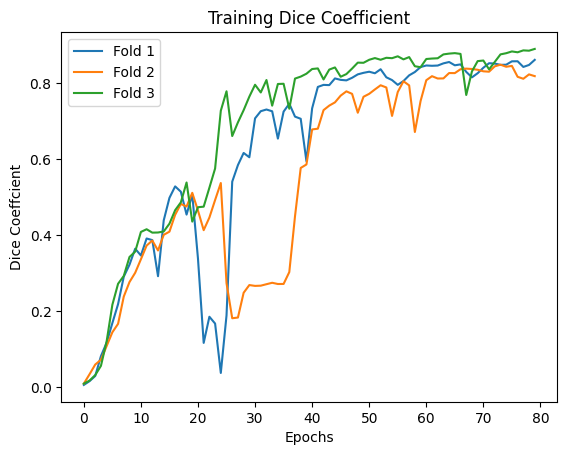

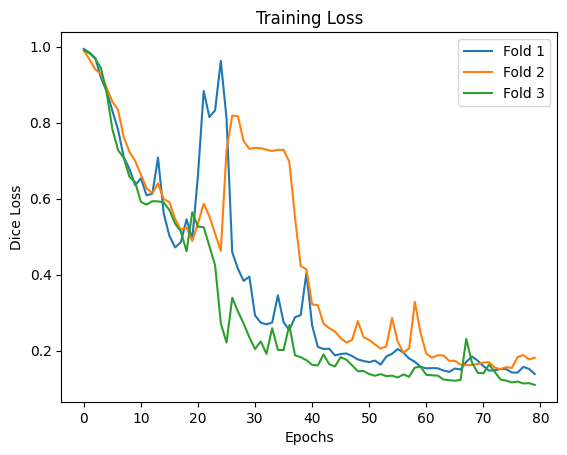

In [ ]:
plt.figure()
plt.plot(dicecoeff1, label='Fold 1')
plt.plot(dicecoeff2, label='Fold 2')
plt.plot(dicecoeff3, label='Fold 3')
plt.title('Training Dice Coefficient')
plt.ylabel('Dice Coeffcient')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(loss1, label='Fold 1')
plt.plot(loss2, label='Fold 2')
plt.plot(loss3, label='Fold 3')
plt.title('Training Loss')
plt.ylabel('Dice Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show()

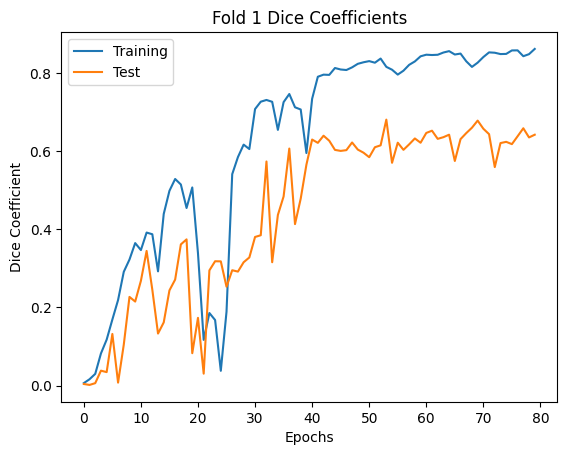

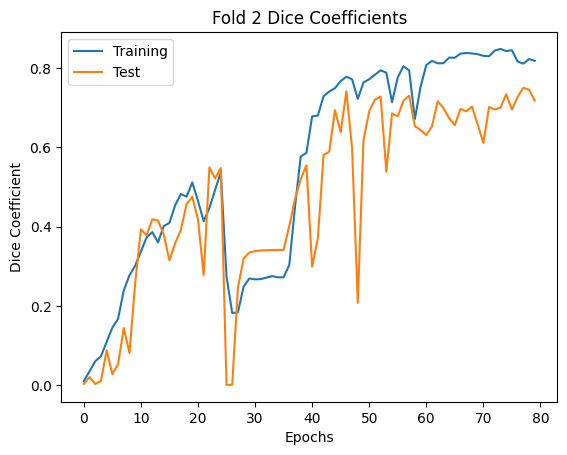

<function matplotlib.pyplot.show(close=None, block=None)>

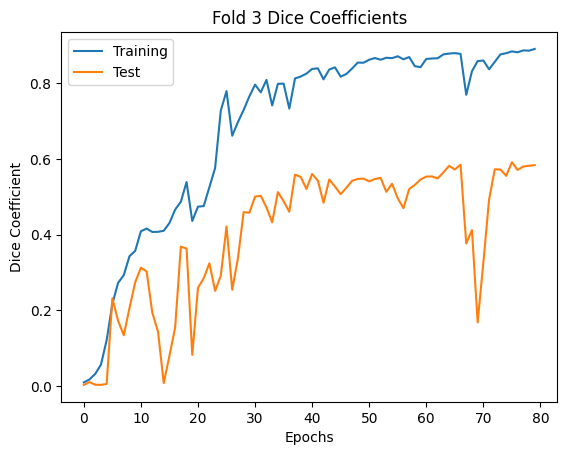

In [ ]:
plt.figure()
plt.title('Fold 1 Dice Coefficients')
plt.plot(dicecoeff1, label='Training')
plt.plot(val_dicecoeff1, label='Test')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.title('Fold 2 Dice Coefficients')
plt.plot(dicecoeff2, label='Training')
plt.plot(val_dicecoeff2, label='Test')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.title('Fold 3 Dice Coefficients')
plt.plot(dicecoeff3, label='Training')
plt.plot(val_dicecoeff3, label='Test')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

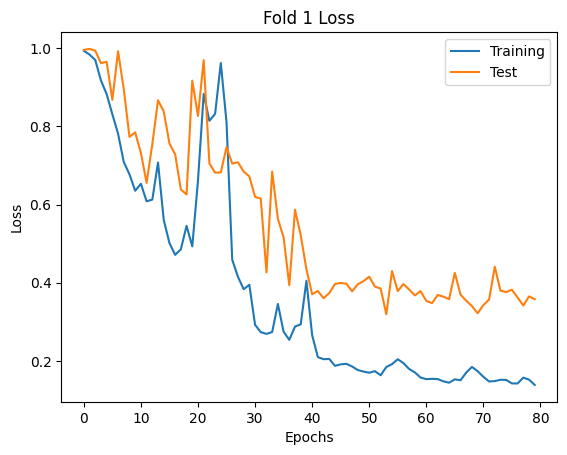

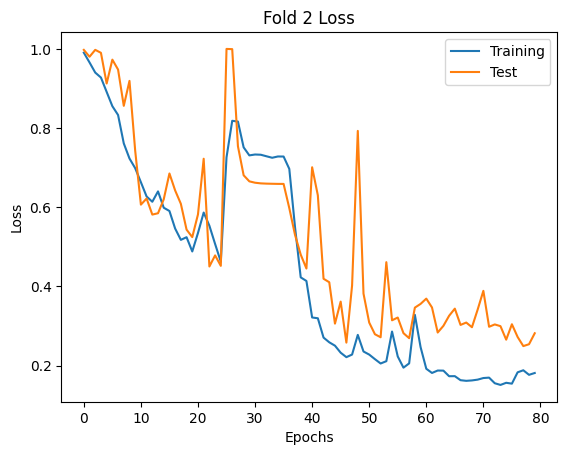

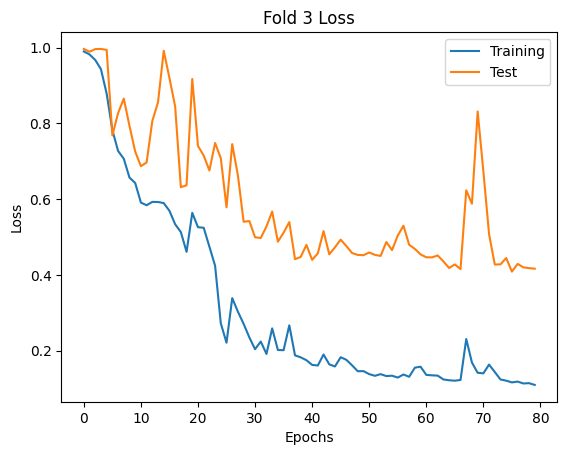

In [ ]:
plt.figure()
plt.title('Fold 1 Loss')
plt.plot(loss1, label='Training')
plt.plot(val_loss1, label='Test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

plt.figure()
plt.title('Fold 2 Loss')
plt.plot(loss2, label='Training')
plt.plot(val_loss2, label='Test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

plt.figure()
plt.title('Fold 3 Loss')
plt.plot(loss3, label='Training')
plt.plot(val_loss3, label='Test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

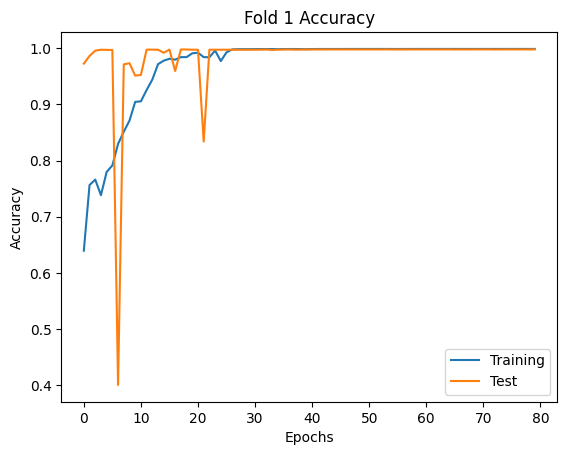

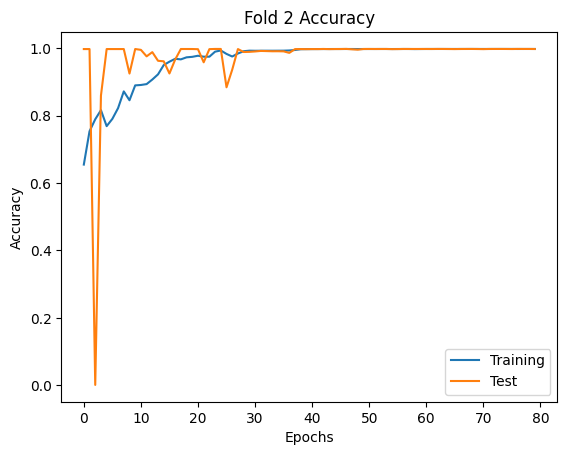

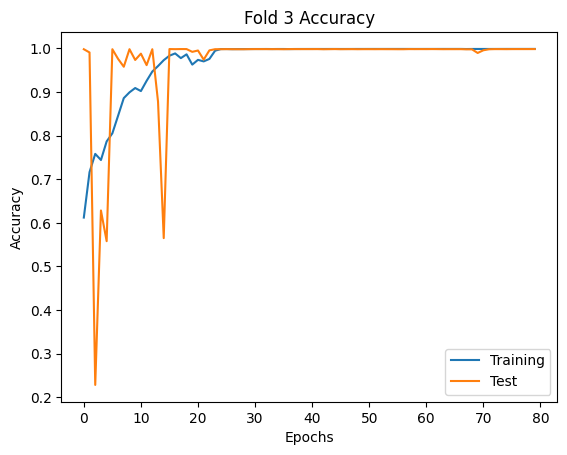

In [ ]:
plt.figure()
plt.title('Fold 1 Accuracy')
plt.plot(accuracy1, label='Training')
plt.plot(val_accurracy1, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

plt.figure()
plt.title('Fold 2 Accuracy')
plt.plot(accuracy2, label='Training')
plt.plot(val_accurracy2, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

plt.figure()
plt.title('Fold 3 Accuracy')
plt.plot(accuracy3, label='Training')
plt.plot(val_accurracy3, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='best')
plt.show

1/1 [==============================] - 1s 513ms/step


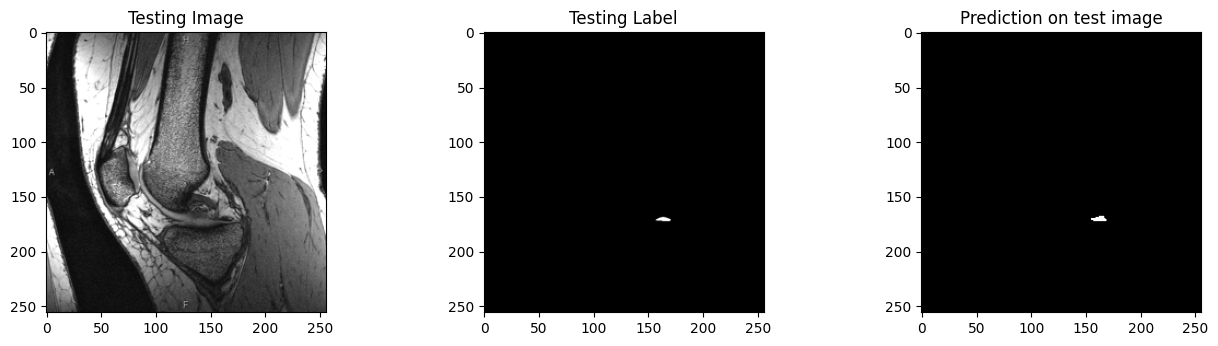

In [ ]:
# Predict on a few images with one of the PL models
PL_model2.load_weights('/content/drive/MyDrive/BME548L_FinalProject/KFold/PLTrainedModels/meniscus_epoch80_f2.hdf5')  #Trained for 50 epochs

test_img_number = random.randint(0, len(x_test))
test_img = x_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (PL_model2.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')


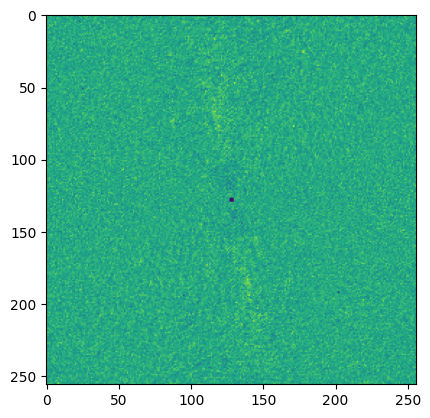

In [ ]:
# check filters
physical_layer_filters = np.array(PL_model2.layers[1].get_filter())

plt.imshow((np.abs(physical_layer_filters)))